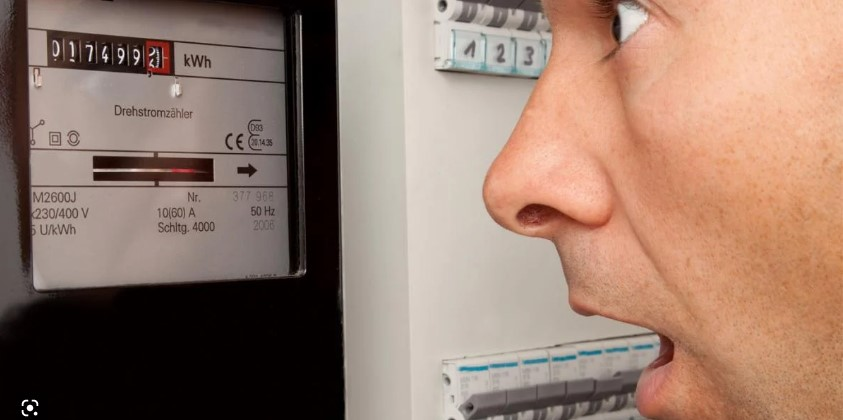

# Project 1 - Group 5
---
### This Project created a tool that analyzes personal energy usage data in relationship to local temperature and tries to predict the future cost of energy for that household taking into account hypothetical temperature changes per season and changes in kWh price based on the best correlation between kWh and natural gas or crude oil. Lastly it utilizes Monte Carlo simulation to predict the future price of kWh, to ultimately come to the future cost of energy for that household. 
---
### General steps of the Tool
1. Import of kWh usage data

2. Import via API of local weather data and save as csv file [aerisweather](https://www.aerisweather.com/)
* for more information you can go to their website or github account:
[aerisweather github](https://github.com/aerisweather/python-tools/blob/main/conditions/historical_conditions_date_range_download.ipynb)

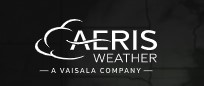

3. Analysis of relationship between household kWh energy usage and temperature sliced into seasons
* The tool explores the relationship of historical kWh energy usage and historical temperatures using linear regression using sklearn library per season.
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

4. Tool predicts future kWh usage for a household based on the regression results of step 3 and manual input for expected temperature changes per season going forward

5. To calculate the future cost of energy (kWh) the tool calculates the correlation between the kWh price and the main two energy commodities in the US. Natural Gas (NG) and Crude Oil (CL)

6. To calculate the future cost of energy (kWh) the tool utilizes Monte Carlo simulation using the product to has the highest correlation with the kWh price

7. Finally the tool will estimate the future cost of energy for a house hold using the following formula:

* **Calculation 1: future kWh usage** 
* slope x hypothetical temperature + intercept
* **Calculation 2 future cost of kWh:**
* future kWh usage x (MC simulation output x correlation factor x current price of kWh) + ((1 - correlation factor) x current price of kWh)
* **Calculation 3 sum of future energy cost**
* sum all cost of kWh


In [1]:
# Import required libraries
from datetime import datetime as dt
import os
from pathlib import Path
import pandas as pd
from pandas import DatetimeIndex
import hvplot.pandas
import sqlalchemy
from sqlalchemy import inspect
from sklearn.linear_model import LinearRegression
from MCForecastTools import MCSimulation
import numpy as np
import holoviews as hv

# Warning filtration
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Select date frame you would like to take into account for analysis
first_date = '2022-01-01'
last_date = '2022-12-31'

### Finished

In [3]:
# Input expected changes in temperature

#hypo_temp_winter = hypo_temp("winter")
#hypo_temp_spring = hypo_temp("spring")
#hypo_temp_summer = hypo_temp("summer")
#hypo_temp_fall = hypo_temp("fall")


### Finished

In [4]:
# ONLY FOR PRESENTATION PURPOSES!!!! Changed to be able to present in Voila
hypo_temp_winter = -10 #hypo_temp("winter")
hypo_temp_spring = +5 #hypo_temp("spring")
hypo_temp_summer = +10 #hypo_temp("summer")
hypo_temp_fall = -6 #hypo_temp("fall")

### Finished

In [5]:
# Define function to request input from user and change input to a float

def hypo_temp(season):
    hypo_temp = input(f'Please provide an estimate on how temperature will change next year for the {season}?')
    hypo_temp = float(hypo_temp)
    return(hypo_temp)


In [6]:
def season_print():
    print(f'Change for winter season: {hypo_temp_winter} Fahrenheit\nChange for spring season: {hypo_temp_spring} Fahrenheit\nChange for summer season: {hypo_temp_summer} Fahrenheit\nChange for fall season: {hypo_temp_fall} Fahrenheit')

In [7]:
print(f'For this presentation we used the following temperature changes to calculate the future energy usage and cost of a household:')
season_print()

For this presentation we used the following temperature changes to calculate the future energy usage and cost of a household:
Change for winter season: -10 Fahrenheit
Change for spring season: 5 Fahrenheit
Change for summer season: 10 Fahrenheit
Change for fall season: -6 Fahrenheit


In [8]:
# Import Weather Data get csv weather data and format 
weather_df = pd.read_csv(Path(
    '../Resources/weather_newyorkny_download_2021_2022_per_hr.csv')
)

### Finished

In [9]:
# CLEAN WEATHER DATA 

try:
    #strip left 10 characters from weather data periods.dateTimeISO date to create date column
    weather_df['date'] = weather_df['periods.dateTimeISO'].str[:10]
    
    weather_df['hour_Weather'] = weather_df['periods.dateTimeISO'].str[11:19]
    
    weather_df['Start Date'] = weather_df['date'] + ' ' + weather_df['hour_Weather']
    
    weather_df['Start Date'] = pd.to_datetime(weather_df['Start Date'])
    
    # change date format to date with actual date from string for easier plotting and use of date column
    weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

    # set date as index in weather data
    weather_df = weather_df.set_index('date')

    # remove unnamed column
    weather_df.drop(columns=["Unnamed: 0"],inplace=True)
    weather_df.drop(columns=["periods.dateTimeISO"],inplace=True) 

except:
    pass
    print('You ran this part already, no worries check if below dataframe is correctly configured')


# Display Weather Data
#weather_df.head()

### Finished

In [10]:
# Import Energy Usage Data
energy_df = pd.read_csv(Path(
    '../Resources/Energy_usage_21_22_per_hr.csv')
)

### Finished

In [11]:
# CLEAN ENERGY USAGE DATA 

try:
    
    #strip left 10 characters from weather data periods.dateTimeISO date to create date column
    energy_df['Start Date'] = pd.to_datetime(energy_df['Start Date'])
    
    # Create hour column to line up both files correctly
    energy_df['hour_Energy'] = energy_df['Start Date'].dt.time
    
    #create new column date seperating start date column into date and time
    energy_df['date'] = pd.to_datetime(energy_df['Start Date']).dt.date
    
    # set date as index in weather data
    energy_df = energy_df.set_index('date')
    
    # Remove orignial start date from data frame (not necessary)
    #energy_df.drop(columns=['Start Date'], inplace=True)

except:
    pass
    print('You already ran this part already, no worries check if below dataframe is correctly configured')


# Display Weather Data
#energy_df.head()


### Finished

In [12]:
# Merge both Energy and Weather dataframe

# select timeframes to analyze
start_date = pd.to_datetime(first_date).date()
end_date = pd.to_datetime(last_date).date()

#select only data within set time frame from weather df
weather_df_select = weather_df.loc[start_date:end_date]

#select only data within set time frame from Energy df
energy_df_select = energy_df.loc[start_date:end_date]

# merge weather data with the energy usage data
merged_data = pd.merge(weather_df_select,energy_df_select, how = 'inner', on = ['Start Date'])

merged_data['date'] = pd.to_datetime(merged_data['Start Date']).dt.date

merged_data= merged_data.set_index('Start Date')


# Add columns day, month, year and month_date to be able to make interactive graphs later (month_date is used to determine which season it is in next step)
merged_data['hour'] = pd.DatetimeIndex(merged_data.index).hour 
merged_data['day'] = pd.DatetimeIndex(merged_data.index).day
merged_data['month'] = pd.DatetimeIndex(merged_data.index).month
merged_data['year'] = pd.DatetimeIndex(merged_data.index).year
merged_data['month_date'] = pd.DatetimeIndex(merged_data.index).strftime('%m%d')
merged_data['month_date'] = merged_data['month_date'].astype(float)

# create a column that displays the season (winter, spring, fall or summer)
merged_data['season'] = np.where((merged_data['month_date'] >= 1221),"winter",
                                np.where((merged_data['month_date'] >=101) & (merged_data['month_date'] <321), "winter",
                                         np.where((merged_data['month_date'] >=321) & (merged_data['month_date'] <621), "spring",
                                                  np.where((merged_data['month_date'] >=621) & (merged_data['month_date'] <921), "summer","fall"))))

### Finished

In [13]:
# include temperature increase
merged_data['hypo_temp'] = np.where((merged_data['season']=='winter'), merged_data['periods.tempF'] + hypo_temp_winter,
                                     np.where((merged_data['season']=='spring'), merged_data['periods.tempF'] + hypo_temp_spring,
                                              np.where((merged_data['season']=='summer'), merged_data['periods.tempF'] + hypo_temp_summer,
                                                       merged_data['periods.tempF'] + hypo_temp_fall)))

try:
    merged_data.drop(columns=["Meter"],inplace=True)
    merged_data.drop(columns=["periods.feelslikeF"],inplace=True) 
    merged_data.drop(columns=["periods.humidity"],inplace=True) 
except:
    pass


### Below shows combined kWh usage data and temperature data provide by Aeris API for new york. Also there is a hypo_temp column that can take into account temperature changes. Highlighted above are the temperature changes per season that were taking into account in this presentation of our results. 

In [14]:
# Display Data
merged_data.head()

### Finished

place.name place.country  periods.tempF hour_Weather  \
Start Date                                                                 
2022-01-01 00:00:00   new york            us          52.16     00:00:00   
2022-01-01 01:00:00   new york            us          52.16     01:00:00   
2022-01-01 02:00:00   new york            us          52.52     02:00:00   
2022-01-01 03:00:00   new york            us          52.16     03:00:00   
2022-01-01 04:00:00   new york            us          52.56     04:00:00   

                      kWh hour_Energy        date  hour  day  month  year  \
Start Date                                                                  
2022-01-01 00:00:00  1.98    00:00:00  2022-01-01     0    1      1  2022   
2022-01-01 01:00:00  1.72    01:00:00  2022-01-01     1    1      1  2022   
2022-01-01 02:00:00  3.19    02:00:00  2022-01-01     2    1      1  2022   
2022-01-01 03:00:00  1.71    03:00:00  2022-01-01     3    1      1  2022   
2022-01-01 04:00:00  1.75    04:00:00  2022-01-01     4    1      1  2022   

                     month_date  season  hypo_temp  
Start Date                                          
2022-01-01 00:00:00       101.0  winter      42.16  
2022-01-01 01:00:00       101.0  winter      42.16  
2022-01-01 02:00:00       101.0  winter      42.52  
2022-01-01 03:00:00       101.0  winter      42.16  
2022-01-01 04:00:00       101.0  winter      42.56

### Create database engine to be able to use sql to query data from database

In [15]:
# Create the connection string for your SQLite database
database_connection_string = 'sqlite:///'

# Pass the connection string to the SQLAlchemy create_engine function
engine = sqlalchemy.create_engine(database_connection_string)

# Confirm that the database engine was created.
engine

### Finished

Engine(sqlite:///)

### Database table name created

In [16]:
# Using the merged data DataFrame, create a table called weather_kwh_usage inside newly created database
merged_data.to_sql(
    'weather_kwh_usage', 
    engine, 
    index=True, 
    if_exists='replace'
)

# Confirm that the table was created by calling the table_names function
inspect(engine).get_table_names()

### Finished

['weather_kwh_usage']

In [17]:
# define function to run SQl query and create Scatter and regression line

def scatter_season(season_input):
# create query with season input
    query = f"""
    SELECT *
    FROM weather_kwh_usage
    WHERE season = '{season_input}'
    """
# Using the query, read the data from the database into a Pandas DataFrame     
    query_df = pd.read_sql_query(query, con=engine)
    
# Prepare data to perform linear regression for the seasonr
    x = np.array(query_df['periods.tempF']).reshape((-1,1))
    y = np.array(query_df['kWh'])

# Set Regression model parameters
    model = LinearRegression().fit(x,y)

# Print r_sq score, model intercept and slope of regression line
    r_sq = model.score(x,y)
    #print(f"coefficient of determination: {r_sq:.4f}")
    print(f"{season_input} intercept: {model.intercept_:.4f}")
    print(f"{season_input} slope: {model.coef_}")

    # determine slope and intercept of regression line
    y_intercept = model.intercept_
    gradient = model.coef_[0]
    
# Create a regression line and a scatter plotter
    slope = hv.Slope(gradient,y_intercept)
    scatter = hv.Scatter((x, y))

# Create plot with scatter and regression line
    combined_scatter = scatter * slope
    graph = combined_scatter.opts(
    height=500,
    width=800,
    xlabel = 'Temperature',
    ylabel = 'kWh Usage',
    title=f'Usage Scatter with Linear Regression {season_input},\n with slope of {gradient:.2f} and intercept of {y_intercept:.2f}')

# Return the scatter of the function
    return(display(combined_scatter))

### Finished    

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 winter season

In [18]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('winter')

### Finished

winter intercept: 4.8511
winter slope: [-0.04722497]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 Spring season

In [19]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('spring')

### Finished

spring intercept: 1.7915
spring slope: [0.0080941]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 Summer season

In [20]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('summer')

### Finished

summer intercept: 1.1343
summer slope: [0.01970737]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

### Below are the results of a linear regression between historical kWh usage and historical temperatures for New York for 2022 Fall season

In [21]:
# Create Scatter for season, with corresponding title, slope and intercept of the season Regression
scatter_season('fall')

### Finished

fall intercept: 4.1366
fall slope: [-0.03146721]


:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

In [22]:
# define function to determine hypothetical usage in case of increase or decrease in temperature depeding on hypo temp input

def hypo_usage_season(season):
# create query with season input
    query_all = f"""
    SELECT * 
    FROM weather_kwh_usage
    """
# Using the query, read the data from the database into a Pandas DataFrame
    all_df = pd.read_sql_query(query_all, con=engine)

# Use only the part of the the dataframe that matches the current input season
    all_df = all_df[(all_df['season']==season)]
    
# Prepare data to perform linear regression for the season
    x = np.array(all_df['periods.tempF']).reshape((-1,1))
    y = np.array(all_df['kWh'])

# Set model parameters
    model = LinearRegression().fit(x,y)

# Display R-square or the season model
    r_sq = model.score(x,y)

# determine slope and intercept of regression line of season
    y_intercept = model.intercept_
    gradient = model.coef_[0]

# Create hypo usage column in dataframe that calculates hypothetical usage based on tempurature change based on current usage regression
    all_df['hypo_usage'] = gradient * all_df['hypo_temp'] + y_intercept

# return updated datafram
    return(all_df)

### Finished

In [23]:
# run all 4 seasons through the hypo_usage_season function and name a variable for the different outputs
winter_df_new_usage = hypo_usage_season('winter')
spring_df_new_usage = hypo_usage_season('spring')
summer_df_new_usage = hypo_usage_season('summer')
fall_df_new_usage = hypo_usage_season('fall')

### Finished

In [24]:
# Concatenate all the data frames into 1 datafram
df_new_usage_winter_spring = pd.concat([winter_df_new_usage,spring_df_new_usage])
df_new_usage_winter_spring_summer = pd.concat([df_new_usage_winter_spring,summer_df_new_usage])
df_new_usage_winter_spring_summer_fall = pd.concat([df_new_usage_winter_spring_summer,fall_df_new_usage])
df_hypo_usage = df_new_usage_winter_spring_summer_fall.sort_values('date')

### Finished

### Below are the results of future kWh usage based on the determined by the different seasonal regression functions and hypothetical temperature changes in column hypo_usage

In [25]:
# Display Data
df_hypo_usage.head()

Start Date place.name place.country  periods.tempF  \
0   2022-01-01 00:00:00.000000   new york            us          52.16   
23  2022-01-01 23:00:00.000000   new york            us          53.78   
22  2022-01-01 22:00:00.000000   new york            us          54.32   
21  2022-01-01 21:00:00.000000   new york            us          55.04   
20  2022-01-01 20:00:00.000000   new york            us          55.22   

   hour_Weather   kWh      hour_Energy        date  hour  day  month  year  \
0      00:00:00  1.98  00:00:00.000000  2022-01-01     0    1      1  2022   
23     23:00:00  2.44  23:00:00.000000  2022-01-01    23    1      1  2022   
22     22:00:00  4.14  22:00:00.000000  2022-01-01    22    1      1  2022   
21     21:00:00  2.38  21:00:00.000000  2022-01-01    21    1      1  2022   
20     20:00:00  2.44  20:00:00.000000  2022-01-01    20    1      1  2022   

    month_date  season  hypo_temp  hypo_usage  
0        101.0  winter      42.16    2.860046  
23       101.0  winter      43.78    2.783542  
22       101.0  winter      44.32    2.758040  
21       101.0  winter      45.04    2.724038  
20       101.0  winter      45.22    2.715538

In [26]:
# Save CSV file to Resources folder under Group5Project1\Niels\Resources
# Set the path and name were to save csv file
csv_output_path = Path('../Resources/df_hypo_usage_per_hr.csv')

# Save dataframe to folder
df_hypo_usage.to_csv(csv_output_path,sep=',')

### Finished

In [27]:
### Calculate new hypothetical usage per day considering temp change and show original usage. 

total_usage_now = df_hypo_usage.groupby('date').sum()
show = total_usage_now[['kWh','hypo_usage']]
show.index = pd.to_datetime(show.index)

# Display Data
show.head()

### Finished

kWh  hypo_usage
date                         
2022-01-01  61.84   66.388948
2022-01-02  65.85   69.203084
2022-01-03  64.26   92.245561
2022-01-04  75.68   94.383436
2022-01-05  66.04   80.853011

### Current analysis took into account the following changes in temperature:

In [28]:
# Print temperature changes taken into account for calculation of hypothetical usage
season_print()

Change for winter season: -10 Fahrenheit
Change for spring season: 5 Fahrenheit
Change for summer season: 10 Fahrenheit
Change for fall season: -6 Fahrenheit


In [29]:
# make usage overviews real and hypothetical per season and summed by year
# Per season

# sum based on season
seasonal_usage = df_hypo_usage.groupby('season').sum()

# select only columns kWh (real) and hypo usage (hypothetical)
seasonal_usage = seasonal_usage[['kWh','hypo_usage']]

# Calculated percentage change between real and hypothetical usage
seasonal_usage['%change'] = (1- (seasonal_usage['kWh'] / seasonal_usage['hypo_usage'])) *100



# Per year
# sum based on year
seasonal_usage_year = df_hypo_usage.groupby('year').sum()

# select only columns kWh (real) and hypo usage (hypothetical)
seasonal_usage_year = seasonal_usage_year[['kWh','hypo_usage']]

# Calculated percentage change between real and hypothetical usage
seasonal_usage_year['%change'] = (1- (seasonal_usage_year['kWh'] / seasonal_usage_year['hypo_usage'])) *100



### Finished

### Below table shows percentage change of kWh usage based on regression and inputted temperature changes per season

In [30]:
# Display season
display(seasonal_usage.round(2))

kWh  hypo_usage  %change
season                              
fall    5358.17     5769.57     7.13
spring  5025.08     5114.44     1.75
summer  5819.18     6249.59     6.89
winter  6601.40     7620.99    13.38

### Below table shows percentage change of kWh usage based on regression and inputted temperature changes per year

In [31]:
# Display year
display(seasonal_usage_year.round(2))

kWh  hypo_usage  %change
year                               
2022  22803.83    24754.59     7.88

In [32]:
# Create an hvplot to show hypothetical usage over the year
hypo_plot = show.hvplot.line(
    x='date',
    y='hypo_usage',
    label='kWh (Hypothetical kWh Usage)',
    xlabel='date',
    ylabel='kWh Usage',
    #groupby='season',
    rot=90,
    hover_color='orange',
    title = f'Energy usage from {first_date} to {last_date} per day in kwh actual and hypothetical based on linear regression' 
).opts(
    yformatter='%.2f',
    line_color='blue',
    hover_line_color='black',
    height=750,
    width=1100,
    xticks=20
)

### Finished

In [33]:
# Create an hvplot to show actual usage over the year
original_plot = show.hvplot.line(
    x='date',
    y='kWh',
    xlabel='date',
    label='kWh (Actual kWh Usage)',
    ylabel='kWh Usage',
    #groupby='season',
    rot=90,
    hover_color='orange',
    title = f'Original kWh usage from {first_date} to {last_date} per hour kwh and temperature data'
).opts(
    yformatter='%.2f',
    line_color='orange',
    hover_line_color='yellow',
    height=750,
    width=1100,
    xticks=20
)

### Finished

### Below graph shows the orginal kWh usage (Orange) compared to the hypothetical kWh usage based on regression (historical kWh usage and historical temperature data) and hypothetical seasonal temperature changes (Blue)

In [34]:
# Create an overlay plot with both above created plots
combined_plot =   hypo_plot * original_plot

#Display combined overlay plot
combined_plot


### Finished

:Overlay
   .Curve.KWh_left_parenthesis_Hypothetical_kWh_Usage_right_parenthesis :Curve   [date]   (hypo_usage)
   .Curve.KWh_left_parenthesis_Actual_kWh_Usage_right_parenthesis       :Curve   [date]   (kWh)

### BEGINNING OF CORRELATION CALCULATIONS ###

In [35]:
# Get WTI Data from Niels's resources folder

WTIcsvpath = Path("../Resources/WTI_Nymex_Max-2023-2013.csv")
df_WTI = pd.read_csv(WTIcsvpath)

df_WTI.head()

Date  Close/Last    Volume   Open   High    Low
0  01/18/2023       79.48   73990.0  80.97  82.38  78.94
1  01/17/2023       80.18  284009.0  80.10  81.23  78.53
2  01/13/2023       79.86  245935.0  78.32  80.11  77.97
3  01/12/2023       78.39  276160.0  77.70  79.16  77.10
4  01/11/2023       77.41  320030.0  74.78  77.84  74.31

In [36]:
# Clean WTI Data, remove unused collumns

df_WTI = df_WTI.drop(columns=['Volume', 'Open', 'High', 'Low'])

# Display sample data
df_WTI.head()

Date  Close/Last
0  01/18/2023       79.48
1  01/17/2023       80.18
2  01/13/2023       79.86
3  01/12/2023       78.39
4  01/11/2023       77.41

In [37]:
# set Date to index for WTI data, this helps with concatination later

df_WTI = df_WTI.set_index("Date")

In [38]:
# Get NG Date from Niels's resources folder

NGcsvpath = Path("../Resources/NG_Nymex_Max-2023-2013.csv")
df_NG = pd.read_csv(NGcsvpath)

In [39]:
# Clean up NG data, drop unused collumns and set the index to Date

df_NG = df_NG.drop(columns=['Volume', 'Open', 'High', 'Low'])

df_NG = df_NG.set_index("Date")

In [40]:
# Combine the two dataframes that we have so far, and make sure it looks okay

df_combined = df_WTI.merge(df_NG, on='Date', suffixes=('_WTI', '_NG'))
df_combined.index = pd.to_datetime(df_combined.index)

# Display sample data
df_combined.head()


Close/Last_WTI  Close/Last_NG
Date                                     
2023-01-18           79.48          3.311
2023-01-17           80.18          3.586
2023-01-13           79.86          3.419
2023-01-12           78.39          3.695
2023-01-11           77.41          3.671

In [41]:
# get the data for KWH prices, verify

csvpath = Path("../Resources/KWH_prices.csv")

KWH_prices = pd.read_csv(csvpath)

# Display sample data
KWH_prices.head()

observation_date  APUS12A72610
0       2015-12-01         0.182
1       2016-01-01         0.186
2       2016-02-01         0.182
3       2016-03-01         0.187
4       2016-04-01         0.188

In [42]:
# Clean KWH data, turn the date collumn into datetime object for concatination
# set date to the Index

KWH_prices = KWH_prices.set_index("observation_date")
KWH_prices.index = pd.to_datetime(KWH_prices.index)
KWH_prices.index.names = ['Date']

# Display sample data
KWH_prices.head()

APUS12A72610
Date                    
2015-12-01         0.182
2016-01-01         0.186
2016-02-01         0.182
2016-03-01         0.187
2016-04-01         0.188

In [43]:
# Combine the KWH data with the other two
# rename the columns for readability

df_combined = pd.merge(df_combined, KWH_prices, left_index=True, right_index=True)
df_combined = df_combined.rename(columns={
  "Close/Last_WTI":"Crude Oil" , 
  "Close/Last_NG":"Natural Gas" , 
  "APUS12A72610":"Kilowatt-Hours"})

In [44]:
# Verify

df_combined.head()

Crude Oil  Natural Gas  Kilowatt-Hours
Date                                              
2022-12-01      81.22        6.738           0.231
2022-11-01      86.21        5.714           0.232
2022-09-01      86.61        9.262           0.245
2022-08-01      93.89        8.283           0.249
2022-07-01     108.43        5.730           0.232

In [45]:
# Calculate correlation of the three data points
df_combined_corr = df_combined.corr()

# sort correlations based on Kilowatt Hours column and display correlation table
df_combined_corr = df_combined_corr.sort_values(by='Kilowatt-Hours',ascending=False)

#create new column with the products of the corr data
df_combined_corr['product'] = df_combined_corr.index

df_combined_corr

Crude Oil  Natural Gas  Kilowatt-Hours         product
Kilowatt-Hours   0.692439     0.753055        1.000000  Kilowatt-Hours
Natural Gas      0.810337     1.000000        0.753055     Natural Gas
Crude Oil        1.000000     0.810337        0.692439       Crude Oil

In [46]:
# Determine which monte carlo portfolio weight to use. Allocate 100% of the weight to the most correlated product [1,0] for natgas and [0,1] for crude

# select 2nd row of df_combined_corr
highest_correlation_prod = df_combined_corr.iloc[1]['product']
display(highest_correlation_prod)

highest_correlation_number = df_combined_corr.iloc[1]['Kilowatt-Hours']
display(highest_correlation_number)

if highest_correlation_prod == 'Natural Gas':
    MC_weight = [1,0]
else: 
    MC_weight = [0,1]
        
print(f'Highest correlated product is {highest_correlation_prod} therefor weights to use in Monte Carlo Simulation is: {MC_weight}')

'Natural Gas'

0.7530547629875469

Highest correlated product is Natural Gas therefor weights to use in Monte Carlo Simulation is: [1, 0]


### BEGINNING OF MC SIMULATION PART ###

In [47]:
# read csv data
ng_df = pd.read_csv('../Resources/NG_Nymex_Max-2023-2013.csv')
wti_df = pd.read_csv('../Resources/WTI_Nymex_Max-2023-2013.csv')

In [48]:
# clean NG data
ng_df=ng_df.drop(columns=['Volume','Open', 'High', 'Low'])
ng_df.columns=('date','close')

# Display sample data
ng_df.head()

date  close
0  01/18/2023  3.311
1  01/17/2023  3.586
2  01/13/2023  3.419
3  01/12/2023  3.695
4  01/11/2023  3.671

In [49]:
# clean WTI data
wti_df=wti_df.drop(columns=['Volume','Open', 'High', 'Low'])
wti_df.columns=('date','close')

# Display sample data
wti_df.head()

date  close
0  01/18/2023  79.48
1  01/17/2023  80.18
2  01/13/2023  79.86
3  01/12/2023  78.39
4  01/11/2023  77.41

In [50]:
# merge WTI and NatGas data
to_merge_dict = {'NG': ng_df , 'WTI': wti_df}
merged_df = pd.concat(to_merge_dict.values(), axis=1, keys=to_merge_dict.keys())

In [51]:
### Create Season indicator in the data to be able to select seasons

merged_df['season_date'] = merged_df['NG','date']
merged_df = merged_df.set_index('season_date')

merged_df['month_date'] = pd.DatetimeIndex(merged_df.index).strftime('%m%d')
merged_df['month_date'] = merged_df['month_date'].astype(float)

# create a column that displays the season (winter, spring, fall or summer)
merged_df['season'] = np.where((merged_df['month_date'] >= 1221),"winter",
                                np.where((merged_df['month_date'] >=101) & (merged_df['month_date'] <321), "winter",
                                         np.where((merged_df['month_date'] >=321) & (merged_df['month_date'] <621), "spring",
                                                  np.where((merged_df['month_date'] >=621) & (merged_df['month_date'] <921), "summer","fall"))))

merged_df.head()

NG                WTI        month_date  season
                   date  close        date  close                   
season_date                                                         
01/18/2023   01/18/2023  3.311  01/18/2023  79.48      118.0  winter
01/17/2023   01/17/2023  3.586  01/17/2023  80.18      117.0  winter
01/13/2023   01/13/2023  3.419  01/13/2023  79.86      113.0  winter
01/12/2023   01/12/2023  3.695  01/12/2023  78.39      112.0  winter
01/11/2023   01/11/2023  3.671  01/11/2023  77.41      111.0  winter

In [52]:
# Define function to select data only applicable to a certain season to use for Monte Carlo simulation
def select_season(season):
    portfolio_data_sliced = merged_df.loc[merged_df['season'] == season]
    portfolio_data_sliced.reindex
    del portfolio_data_sliced['month_date']
    del portfolio_data_sliced['season']
    
    return(portfolio_data_sliced)

In [53]:
# Define function to run selected season data and adjust for length of season and balance weight to most correlated energy source with kWh
def monte_carlo_sim(MC_weight,season,input_season_days):
        
    MC_simulation = MCSimulation(
        portfolio_data= season,
        weights=MC_weight, # use MC_weight fully allocated to most correlated product determined 
        num_simulation=100,
        num_trading_days= input_season_days,
    )
    
    return(MC_simulation)

In [54]:
# 1. run defined select_season function with season indicator, 2. run MC simulation with seasonal data and length of season

winter = select_season('winter')
winter =  monte_carlo_sim(MC_weight,winter,89)

spring = select_season('spring')
spring =  monte_carlo_sim(MC_weight,spring,93)

summer = select_season('summer')
summer =  monte_carlo_sim(MC_weight,summer,94)

fall = select_season('fall')
fall =  monte_carlo_sim(MC_weight,fall,89)

In [55]:
# Display the seasonal data
display(winter.portfolio_data.tail())
display(spring.portfolio_data.tail())
display(summer.portfolio_data.tail())
display(fall.portfolio_data.tail())

NG                             WTI                    
                   date  close daily_return        date  close daily_return
season_date                                                                
01/25/2013   01/25/2013  3.444     0.047127  01/25/2013  95.88    -0.005807
01/24/2013   01/24/2013  3.446     0.000581  01/24/2013  95.95     0.000730
01/23/2013   01/23/2013  3.554     0.031341  01/23/2013  95.23    -0.007504
01/22/2013   01/22/2013  3.558     0.001125  01/22/2013  96.24     0.010606
01/21/2013   01/21/2013  3.566     0.002248  01/21/2013  95.56    -0.007066

NG                             WTI                    
                   date  close daily_return        date  close daily_return
season_date                                                                
03/27/2013   03/27/2013  4.068     0.010934  03/27/2013  96.58    -0.006685
03/26/2013   03/26/2013  3.976    -0.022616  03/26/2013  96.34    -0.002485
03/25/2013   03/25/2013  3.865    -0.027918  03/25/2013  94.81    -0.015881
03/22/2013   03/22/2013  3.927     0.016041  03/22/2013  93.71    -0.011602
03/21/2013   03/21/2013  3.935     0.002037  03/21/2013  92.45    -0.013446

NG                             WTI                    
                   date  close daily_return        date  close daily_return
season_date                                                                
06/27/2013   06/27/2013  3.582     0.004769  06/27/2013  97.05     0.005075
06/26/2013   06/26/2013  3.707     0.034897  06/26/2013  95.50    -0.015971
06/25/2013   06/25/2013  3.647    -0.016186  06/25/2013  95.32    -0.001885
06/24/2013   06/24/2013  3.739     0.025226  06/24/2013  95.18    -0.001469
06/21/2013   06/21/2013  3.771     0.008558  06/21/2013  93.69    -0.015655

NG                             WTI                     
                   date  close daily_return        date   close daily_return
season_date                                                                 
09/27/2013   09/27/2013  3.589     0.008146  09/27/2013  102.87     0.005277
09/26/2013   09/26/2013  3.498    -0.025355  09/26/2013  103.03     0.001555
09/25/2013   09/25/2013  3.493    -0.001429  09/25/2013  102.66    -0.003591
09/24/2013   09/24/2013  3.492    -0.000286  09/24/2013  103.13     0.004578
09/23/2013   09/23/2013  3.602     0.031501  09/23/2013  103.59     0.004460

In [56]:
# Run monte carlo simulation for the 4 different seasons

winter.calc_cumulative_return()
spring.calc_cumulative_return()
summer.calc_cumulative_return()
fall.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number

0         1         2         3         4         5         6   \
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1   1.021489  1.055079  1.043938  1.019980  0.940979  0.993121  0.907542   
2   1.030405  1.055285  1.117579  1.021604  0.928530  1.040447  0.856828   
3   1.126819  1.019326  1.071235  1.100328  1.016563  1.010128  0.893331   
4   1.186906  0.962078  1.087419  1.091173  1.047856  1.005620  0.896543   
..       ...       ...       ...       ...       ...       ...       ...   
85  0.571227  0.840103  1.363092  1.074676  0.510693  0.494323  1.091073   
86  0.522944  0.908914  1.287315  1.033551  0.482292  0.513717  1.130843   
87  0.536177  0.927386  1.332151  1.073649  0.512448  0.542210  0.931566   
88  0.496183  0.872793  1.261462  1.056576  0.474358  0.563430  0.930146   
89  0.486422  0.868012  1.228740  1.133418  0.538994  0.619144  0.883008   

          7         8         9   ...        90        91        92        93  \
0   1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1   1.053701  0.996674  1.064108  ...  1.136028  0.970583  0.984909  0.997753   
2   1.122408  0.886883  1.084682  ...  1.132114  0.907052  1.178821  0.994916   
3   1.047033  0.880215  1.121397  ...  1.189145  0.904699  1.028112  0.918649   
4   1.108551  0.868311  1.093393  ...  1.232005  0.923461  0.974160  0.983928   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  0.808550  2.075876  1.077659  ...  1.434233  0.611216  1.207989  1.526105   
86  0.757972  2.139156  0.880694  ...  1.593390  0.638528  1.168042  1.456878   
87  0.723673  2.108760  0.978050  ...  1.652915  0.672142  1.207299  1.624468   
88  0.711022  1.993420  0.966806  ...  1.553727  0.741190  1.166064  1.642847   
89  0.752651  2.012768  0.982558  ...  1.473636  0.752738  1.183130  1.558988   

          94        95        96        97        98        99  
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1   0.977383  1.002810  1.060990  0.979994  1.013794  0.963199  
2   0.979644  0.958092  1.141646  1.010348  1.100393  0.981854  
3   0.968366  0.918675  1.022803  1.033768  1.064845  0.944492  
4   0.924865  0.950364  1.021692  1.021956  0.989336  0.972633  
..       ...       ...       ...       ...       ...       ...  
85  1.269242  1.676860  0.322786  1.335859  0.636071  0.647461  
86  1.288421  1.745832  0.340693  1.471995  0.647393  0.573991  
87  1.269106  1.644905  0.325688  1.513422  0.656827  0.616216  
88  1.260858  1.618752  0.305999  1.554475  0.621891  0.630169  
89  1.382608  1.613027  0.294780  1.581570  0.657829  0.670532  

[90 rows x 100 columns]

<AxesSubplot:title={'center':'100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 89 Trading Days.'}>

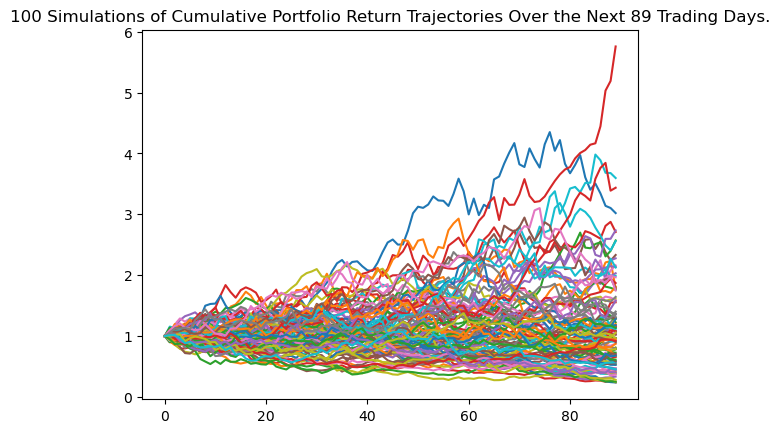

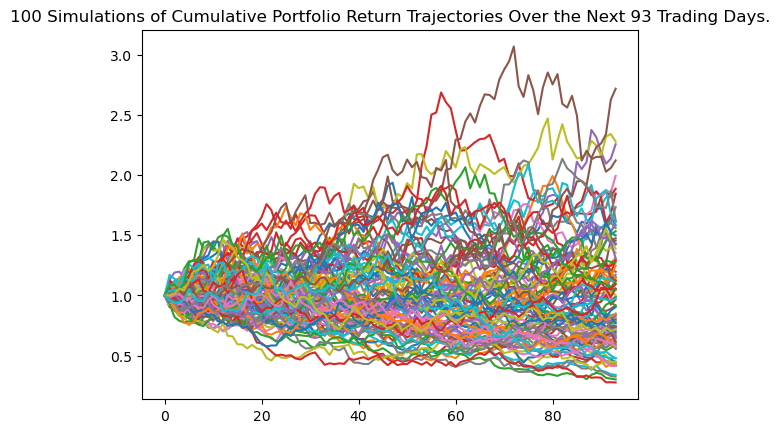

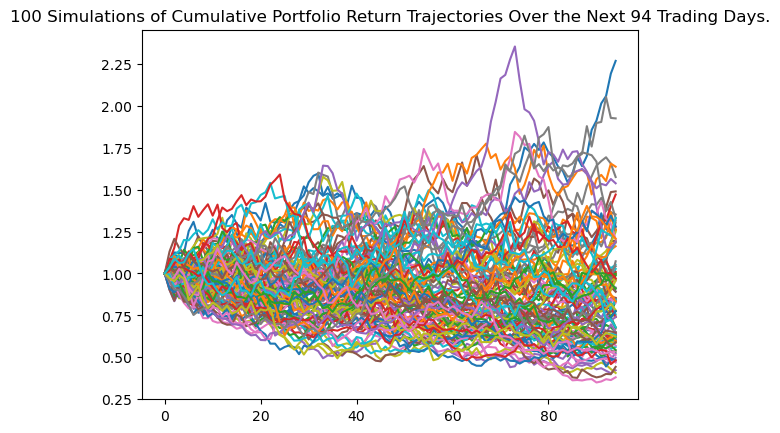

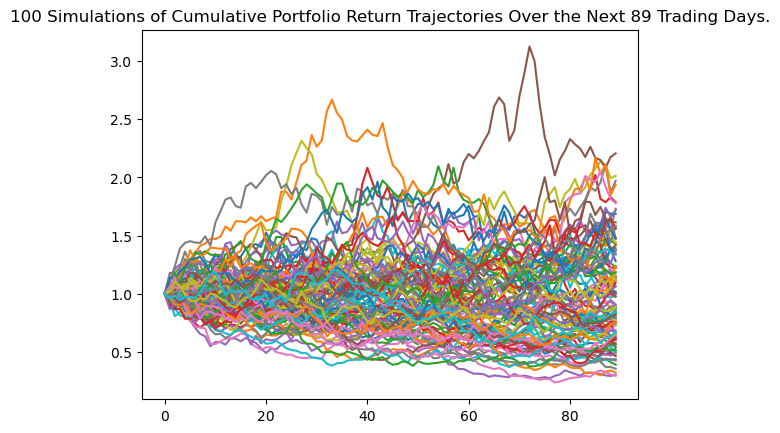

In [57]:
# plot simulations per season

winter.plot_simulation()
spring.plot_simulation()
summer.plot_simulation()
fall.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

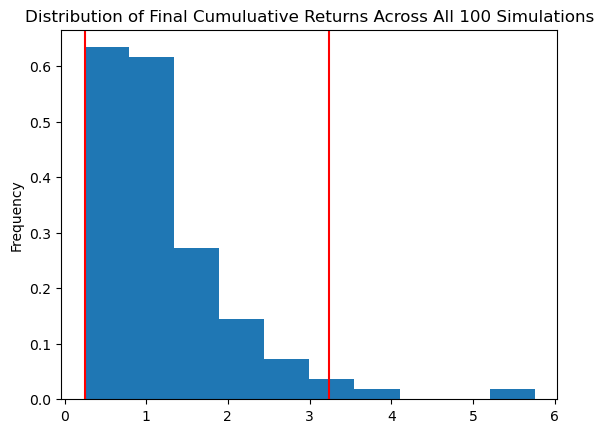

In [58]:
display(winter.plot_distribution())

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

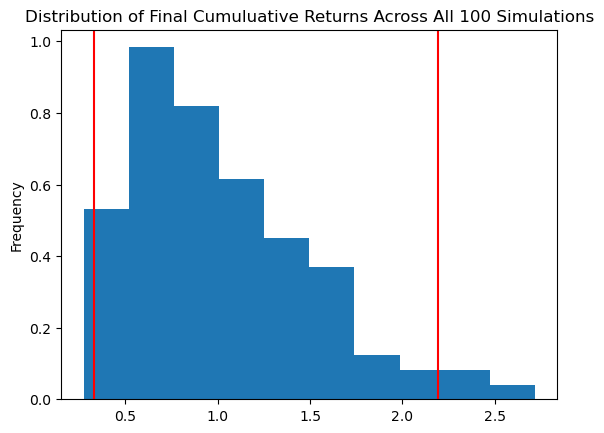

In [59]:
display(spring.plot_distribution())

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

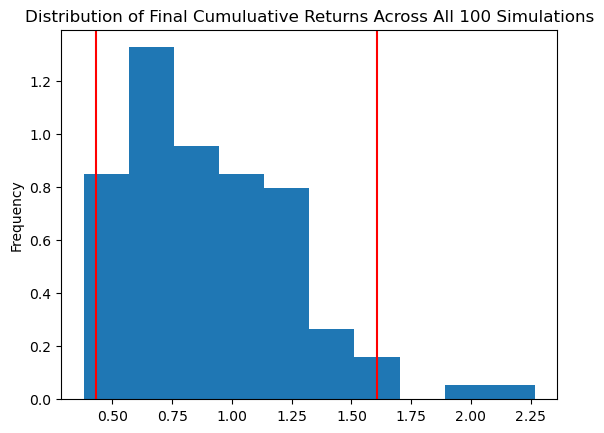

In [60]:
display(summer.plot_distribution())

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 100 Simulations'}, ylabel='Frequency'>

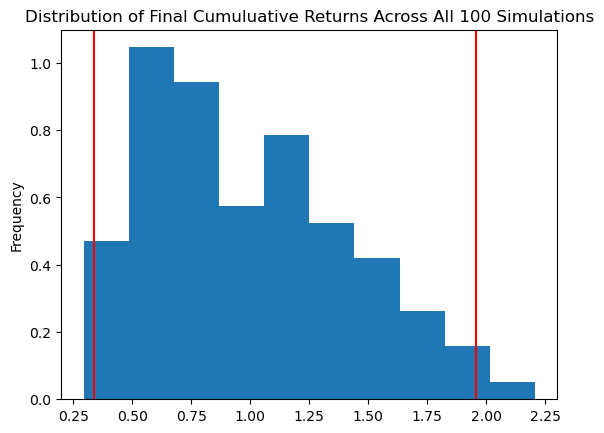

In [61]:
display(fall.plot_distribution())

In [62]:
# define function that runs the summarize cumulative return function per season
def season_mc_values(season):
    season_mc = season.summarize_cumulative_return()
    return(season_mc)

In [101]:
# Run season_mc_values function with seasonal input and extract 95% lower and upper levels per season
winter_results = season_mc_values(winter)
winter_low = winter_results.iloc[8]
winter_high = winter_results.iloc[9]

spring_results = season_mc_values(spring)
spring_low = spring_results.iloc[8]
spring_high = spring_results.iloc[9]

summer_results = season_mc_values(summer)
summer_low = summer_results.iloc[8]
summer_high = summer_results.iloc[9]

fall_results = season_mc_values(fall)
fall_low = fall_results.iloc[8]
fall_high = fall_results.iloc[9]

#print(winter_high,spring_high,summer_high,fall_high)
#print(winter_low,spring_low,summer_low,fall_low)

In [102]:
#select only data within set time frame from analyzis as set in "Select date frame you would like to take into account for analysis"
kwh_input_prices = KWH_prices.copy()
kwh_input_prices['month'] = pd.DatetimeIndex(kwh_input_prices.index).month
kwh_input_prices['year'] = pd.DatetimeIndex(kwh_input_prices.index).year

kwh_input_prices = kwh_input_prices.rename(columns={
  "APUS12A72610":"monthly_kwh_price"})

kwh_input_prices.head()

monthly_kwh_price  month  year
Date                                      
2015-12-01              0.182     12  2015
2016-01-01              0.186      1  2016
2016-02-01              0.182      2  2016
2016-03-01              0.187      3  2016
2016-04-01              0.188      4  2016

In [103]:
def kwh_input(month,year):
    kwh_input = kwh_input_prices[(kwh_input_prices['month'] == month) & (kwh_input_prices['year']== year)]
    kwh_input_select = kwh_input['monthly_kwh_price']
    return(kwh_input_select)     

In [104]:
# select KWH price for months and year

kwh_dec = kwh_input(12,2022)
kwh_nov = kwh_input(11,2022)
kwh_oct = kwh_input(10,2022)
kwh_sep = kwh_input(9,2022)
kwh_aug = kwh_input(8,2022)
kwh_jul = kwh_input(7,2022)
kwh_jun = kwh_input(6,2022)
kwh_may = kwh_input(5,2022)
kwh_apr = kwh_input(4,2022)
kwh_mar = kwh_input(3,2022)
kwh_feb = kwh_input(2,2022)
kwh_jan = kwh_input(1,2022)

In [105]:
# Make a copy of the original df_hypo_usage file not to make any changes in original file
df_hypo_usage_cost_calc = df_hypo_usage.copy()

In [106]:
df_hypo_usage_cost_calc['kwh_price_original'] = np.where((df_hypo_usage_cost_calc['month'] == 12) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_dec,
                                                         np.where((df_hypo_usage_cost_calc['month'] == 11) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_nov,
                                                                  np.where((df_hypo_usage_cost_calc['month'] == 10) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_oct,
                                                                           np.where((df_hypo_usage_cost_calc['month'] == 9) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_sep,
                                                                                    np.where((df_hypo_usage_cost_calc['month'] == 8) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_aug,
                                                                                             np.where((df_hypo_usage_cost_calc['month'] == 7) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_jul,
                                                                                                      np.where((df_hypo_usage_cost_calc['month'] == 6) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_jun,
                                                                                                               np.where((df_hypo_usage_cost_calc['month'] == 5) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_may,
                                                                                                                        np.where((df_hypo_usage_cost_calc['month'] == 4) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_apr,
                                                                                                                                 np.where((df_hypo_usage_cost_calc['month'] == 3) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_mar,
                                                                                                                                          np.where((df_hypo_usage_cost_calc['month'] == 2) & (df_hypo_usage_cost_calc['year'] == 2022), kwh_feb,
                                                                                                                                                   kwh_jan)))))))))))

df_hypo_usage_cost_calc.head()
                                

Start Date place.name place.country  periods.tempF  \
0   2022-01-01 00:00:00.000000   new york            us          52.16   
23  2022-01-01 23:00:00.000000   new york            us          53.78   
22  2022-01-01 22:00:00.000000   new york            us          54.32   
21  2022-01-01 21:00:00.000000   new york            us          55.04   
20  2022-01-01 20:00:00.000000   new york            us          55.22   

   hour_Weather   kWh      hour_Energy        date  hour  day  month  year  \
0      00:00:00  1.98  00:00:00.000000  2022-01-01     0    1      1  2022   
23     23:00:00  2.44  23:00:00.000000  2022-01-01    23    1      1  2022   
22     22:00:00  4.14  22:00:00.000000  2022-01-01    22    1      1  2022   
21     21:00:00  2.38  21:00:00.000000  2022-01-01    21    1      1  2022   
20     20:00:00  2.44  20:00:00.000000  2022-01-01    20    1      1  2022   

    month_date  season  hypo_temp  hypo_usage  kwh_price_original  
0        101.0  winter      42.16    2.860046               0.256  
23       101.0  winter      43.78    2.783542               0.256  
22       101.0  winter      44.32    2.758040               0.256  
21       101.0  winter      45.04    2.724038               0.256  
20       101.0  winter      45.22    2.715538               0.256

In [110]:
df_hypo_usage_cost_calc['mc_high'] = np.where((df_hypo_usage_cost_calc['season'] == 'winter'), winter_high,
                                                         np.where((df_hypo_usage_cost_calc['season'] == 'spring'), spring_high,
                                                                  np.where((df_hypo_usage_cost_calc['season'] == 'summer'), summer_high,
                                                                           fall_high)))

df_hypo_usage_cost_calc['mc_low'] = np.where((df_hypo_usage_cost_calc['season'] == 'winter'),winter_low,
                                                         np.where((df_hypo_usage_cost_calc['season'] == 'spring'),spring_low,
                                                                  np.where((df_hypo_usage_cost_calc['season'] == 'summer'),summer_low,
                                                                           fall_low)))
                                                                  
df_hypo_usage_cost_calc.head()

Start Date place.name place.country  periods.tempF  \
0   2022-01-01 00:00:00.000000   new york            us          52.16   
23  2022-01-01 23:00:00.000000   new york            us          53.78   
22  2022-01-01 22:00:00.000000   new york            us          54.32   
21  2022-01-01 21:00:00.000000   new york            us          55.04   
20  2022-01-01 20:00:00.000000   new york            us          55.22   

   hour_Weather   kWh      hour_Energy        date  hour  day  month  year  \
0      00:00:00  1.98  00:00:00.000000  2022-01-01     0    1      1  2022   
23     23:00:00  2.44  23:00:00.000000  2022-01-01    23    1      1  2022   
22     22:00:00  4.14  22:00:00.000000  2022-01-01    22    1      1  2022   
21     21:00:00  2.38  21:00:00.000000  2022-01-01    21    1      1  2022   
20     20:00:00  2.44  20:00:00.000000  2022-01-01    20    1      1  2022   

    month_date  season  hypo_temp  hypo_usage  kwh_price_original   mc_high  \
0        101.0  winter      42.16    2.860046               0.256  3.238976   
23       101.0  winter      43.78    2.783542               0.256  3.238976   
22       101.0  winter      44.32    2.758040               0.256  3.238976   
21       101.0  winter      45.04    2.724038               0.256  3.238976   
20       101.0  winter      45.22    2.715538               0.256  3.238976   

      mc_low  
0   0.247152  
23  0.247152  
22  0.247152  
21  0.247152  
20  0.247152

In [111]:
# calculate orginal cost of energy, and MC simulated cost of energy with 95% confidence interval taking into account correlation of NG to kWh
df_hypo_usage_cost_calc['org_cost'] = df_hypo_usage_cost_calc['kWh'] * df_hypo_usage_cost_calc['kwh_price_original']
df_hypo_usage_cost_calc['org_mc_low_cost'] = ((df_hypo_usage_cost_calc['kWh'] * df_hypo_usage_cost_calc['mc_low'] * highest_correlation_number) + ((1-highest_correlation_number) * df_hypo_usage_cost_calc['kWh'])) * df_hypo_usage_cost_calc['kwh_price_original'] 
df_hypo_usage_cost_calc['org_mc_high_cost'] = ((df_hypo_usage_cost_calc['kWh'] * df_hypo_usage_cost_calc['mc_high'] * highest_correlation_number) + ((1-highest_correlation_number) * df_hypo_usage_cost_calc['kWh'])) * df_hypo_usage_cost_calc['kwh_price_original'] 
df_hypo_usage_cost_calc['hypo_mc_low_cost'] = ((df_hypo_usage_cost_calc['hypo_usage'] * df_hypo_usage_cost_calc['mc_low'] * highest_correlation_number) + ((1-highest_correlation_number) * df_hypo_usage_cost_calc['hypo_usage'])) * df_hypo_usage_cost_calc['kwh_price_original'] 
df_hypo_usage_cost_calc['hypo_mc_high_cost'] = ((df_hypo_usage_cost_calc['hypo_usage'] * df_hypo_usage_cost_calc['mc_high'] * highest_correlation_number) + ((1-highest_correlation_number) * df_hypo_usage_cost_calc['hypo_usage'])) * df_hypo_usage_cost_calc['kwh_price_original'] 

df_hypo_usage_cost_calc.head()

Start Date place.name place.country  periods.tempF  \
0   2022-01-01 00:00:00.000000   new york            us          52.16   
23  2022-01-01 23:00:00.000000   new york            us          53.78   
22  2022-01-01 22:00:00.000000   new york            us          54.32   
21  2022-01-01 21:00:00.000000   new york            us          55.04   
20  2022-01-01 20:00:00.000000   new york            us          55.22   

   hour_Weather   kWh      hour_Energy        date  hour  day  ...  hypo_temp  \
0      00:00:00  1.98  00:00:00.000000  2022-01-01     0    1  ...      42.16   
23     23:00:00  2.44  23:00:00.000000  2022-01-01    23    1  ...      43.78   
22     22:00:00  4.14  22:00:00.000000  2022-01-01    22    1  ...      44.32   
21     21:00:00  2.38  21:00:00.000000  2022-01-01    21    1  ...      45.04   
20     20:00:00  2.44  20:00:00.000000  2022-01-01    20    1  ...      45.22   

    hypo_usage  kwh_price_original   mc_high    mc_low  org_cost  \
0     2.860046               0.256  3.238976  0.247152   0.50688   
23    2.783542               0.256  3.238976  0.247152   0.62464   
22    2.758040               0.256  3.238976  0.247152   1.05984   
21    2.724038               0.256  3.238976  0.247152   0.60928   
20    2.715538               0.256  3.238976  0.247152   0.62464   

    org_mc_low_cost  org_mc_high_cost  hypo_mc_low_cost  hypo_mc_high_cost  
0          0.219512          1.361516          0.317077           1.966666  
23         0.270509          1.677828          0.308596           1.914059  
22         0.458979          2.846806          0.305768           1.896523  
21         0.263857          1.636570          0.301999           1.873142  
20         0.270509          1.677828          0.301056           1.867297  

[5 rows x 24 columns]

In [125]:
costs_overview = df_hypo_usage_cost_calc[['date','org_cost', 'hypo_mc_low_cost','hypo_mc_high_cost']]

cost_per_day = costs_overview.groupby('date').sum()
cost_per_day

org_cost  hypo_mc_low_cost  hypo_mc_high_cost
date                                                     
2022-01-01  15.83104          7.360171          45.651316
2022-01-02  16.85760          7.672158          47.586412
2022-01-03  16.45056         10.226749          63.431209
2022-01-04  19.37408         10.463763          64.901285
2022-01-05  16.90624          8.963721          55.597301
...              ...               ...                ...
2022-12-27  20.61213          9.077905          56.305529
2022-12-28  18.13812          8.144671          50.517160
2022-12-29  18.98820          7.678337          47.624733
2022-12-30  14.63154          6.900720          42.801581
2022-12-31  11.90343          6.719355          41.676667

[364 rows x 3 columns]

In [122]:
costs_overview.groupby('year').sum()

org_cost  hypo_mc_low_cost  hypo_mc_high_cost
year                                                 
2022  5369.90852       2902.892567       11515.864414

In [126]:
cost_per_day.hvplot(
x='date')

:NdOverlay   [Variable]
   :Curve   [date]   (value)